## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib

# from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.utils.franka import reconstruct_actions
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-16 16:14:55.909 | INFO     |  Running on cuda:0


In [3]:
task = 'Drawer'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-16 16:14:57.419 | INFO     |  Loading dataset(s): 
2024-08-16 16:14:57.419 | INFO     |    Initializing datasete using /home/hartzj/MT-GMM/data/Drawer/demos/metadata.json
2024-08-16 16:14:57.421 | INFO     |    Extracted gt object labels []
2024-08-16 16:14:57.421 | INFO     |    Extracted tsdf object labels []
2024-08-16 16:14:57.422 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'exp',
}


In [5]:
observations = scene_data.get_demos(**kp_config)

reconstruct_actions(observations)

n_obs = len(observations)


In [6]:
demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=True,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True,
    kp_indeces=list(range(4)),
)

demos = Demos(observations, **data_kwargs)

2024-08-16 16:15:04.638 | INFO     |  Subsampling to length 863 using strategy mean-length.


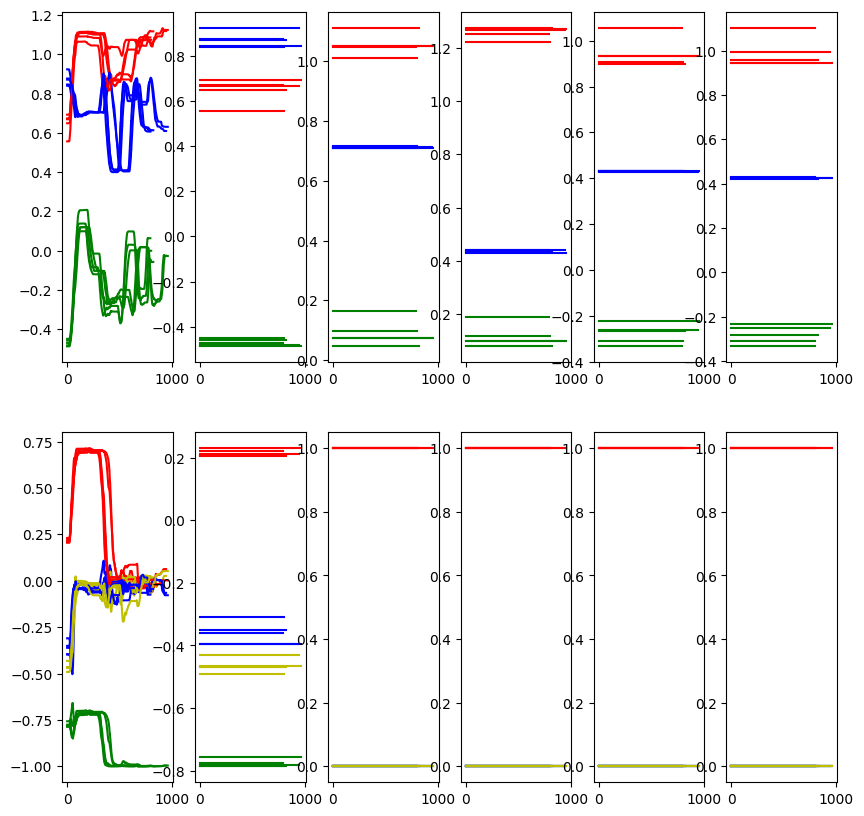

In [7]:
demos.debug_trajs()

In [8]:
tpgmm_config = TPGMMConfig(
    n_components=50,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    action_as_orientation=False,
    action_with_magnitude=False,

    add_gripper_action=True,

    reg_init_diag=5e-5,
    reg_diag_gripper=2e-5,
    reg_em_finish_diag_gripper=2e-5,

    reg_shrink=1e-3,
    reg_diag=5e-5,

    reg_em_finish_shrink=1e-3,
    reg_em_finish_diag=5e-5,

    fix_first_component=False,
    fix_last_component=False,

    trans_cov_mask_t_pos_corr=False,

    em_steps=1,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
)

demo_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,

    components_prop_to_len=True,

    use_gripper_states=False,

    min_end_distance=35,
    min_len=5,

    velocity_threshold=0.0006,
    max_idx_distance=1,
)

cascade_config = CascadeConfig(
    min_prob=0.05,
    kl_keep_rotation_dim=False
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demo_segmentation_config,
    cascade=cascade_config,
)


In [9]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-16 16:15:06.256 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:15:06.256 | INFO     |  Performing fitting actions: [INIT]
2024-08-16 16:15:06.256 | INFO     |  Segmenting trajectories


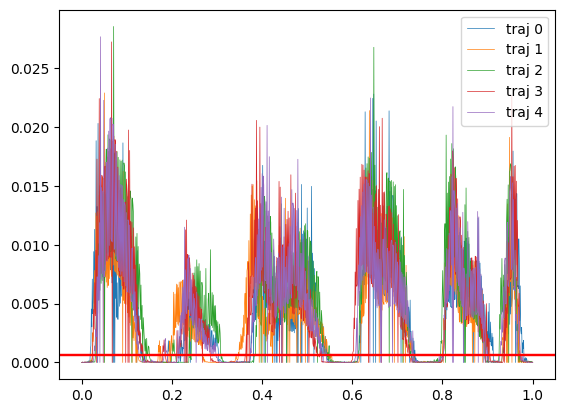

2024-08-16 16:15:06.475 | INFO     |  Creating segement of demos.
2024-08-16 16:15:06.477 | INFO     |  Subsampling to length 137 using strategy mean-length.
2024-08-16 16:15:06.478 | INFO     |  Creating segement of demos.
2024-08-16 16:15:06.479 | INFO     |  Subsampling to length 36 using strategy mean-length.
2024-08-16 16:15:06.480 | INFO     |  Creating segement of demos.
2024-08-16 16:15:06.482 | INFO     |  Subsampling to length 109 using strategy mean-length.
2024-08-16 16:15:06.483 | INFO     |  Creating segement of demos.
2024-08-16 16:15:06.485 | INFO     |  Subsampling to length 214 using strategy mean-length.
2024-08-16 16:15:06.485 | INFO     |  Creating segement of demos.
2024-08-16 16:15:06.488 | INFO     |  Subsampling to length 163 using strategy mean-length.
2024-08-16 16:15:06.489 | INFO     |  Creating segement of demos.
2024-08-16 16:15:06.491 | INFO     |  Subsampling to length 129 using strategy mean-length.
2024-08-16 16:15:06.492 | INFO     |  Creating segeme

Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:07.016 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:07.016 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:07.347 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:07.348 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:07.693 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:07.693 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:08.061 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:08.061 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:08.413 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-16 16:15:08.413 | INFO     |  kp 0       score (rel):     -0 (0.204)
2024-08-16 16:15:08.413 | INFO     |  kp 1       score (rel):     -1 (0.815)
2024-08-16 16:15:08.414 | INFO     |  kp 2       score (rel):     -0 (0.115)
2024-08-16 16:15:08.414 | INFO     |  kp 3       score (rel):     -0 (0.117)
2024-08-16 16:15:08.414 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:08.492 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:08.493 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:15:08.496 | INFO     |    Changing number of components to 2


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:08.550 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:08.550 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:08.627 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:08.627 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:08.751 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:08.752 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:08.856 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:08.857 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:08.925 | INFO     |  ee_init    score (rel):     -0 (0.001)
2024-08-16 16:15:08.925 | INFO     |  kp 0       score (rel):     -0 (0.265)
2024-08-16 16:15:08.926 | INFO     |  kp 1       score (rel):     -1 (1.000)
2024-08-16 16:15:08.926 | INFO     |  kp 2       score (rel):     -0 (0.004)
2024-08-16 16:15:08.926 | INFO     |  kp 3       score (rel):     -0 (0.006)
2024-08-16 16:15:08.926 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:08.927 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:08.927 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:15:08.937 | INFO     |    Changing number of components to 6


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:09.182 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:09.183 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:09.441 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:09.442 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:09.717 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:09.717 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:09.972 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:09.973 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:10.212 | INFO     |  ee_init    score (rel):     -0 (0.005)
2024-08-16 16:15:10.213 | INFO     |  kp 0       score (rel):     -0 (0.278)
2024-08-16 16:15:10.213 | INFO     |  kp 2       score (rel):     -0 (0.013)
2024-08-16 16:15:10.213 | INFO     |  kp 3       score (rel):     -0 (0.016)
2024-08-16 16:15:10.213 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:10.214 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:10.215 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:15:10.292 | INFO     |    Changing number of components to 12


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:10.943 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:10.943 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:11.649 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:11.650 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:12.366 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:12.366 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:13.119 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:13.120 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:13.849 | INFO     |  ee_init    score (rel):     -0 (0.481)
2024-08-16 16:15:13.849 | INFO     |  kp 0       score (rel):     -0 (0.371)
2024-08-16 16:15:13.849 | INFO     |  kp 2       score (rel):     -1 (0.634)
2024-08-16 16:15:13.849 | INFO     |  kp 3       score (rel):     -1 (0.867)
2024-08-16 16:15:13.850 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:13.926 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:13.926 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:15:13.931 | INFO     |    Changing number of components to 9


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:14.320 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:14.320 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:14.804 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:14.805 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:15.293 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:15.294 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:15.773 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:15.773 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:16.243 | INFO     |  ee_init    score (rel):     -0 (0.823)
2024-08-16 16:15:16.243 | INFO     |  kp 0       score (rel):     -0 (0.796)
2024-08-16 16:15:16.243 | INFO     |  kp 1       score (rel):     -1 (0.951)
2024-08-16 16:15:16.243 | INFO     |  kp 2       score (rel):     -1 (1.000)
2024-08-16 16:15:16.243 | INFO     |  kp 3       score (rel):     -0 (0.802)
2024-08-16 16:15:16.244 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:16.320 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:16.320 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:16.617 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:16.617 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:16.939 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:16.939 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:17.268 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:17.269 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:17.597 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:17.598 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:17.946 | INFO     |  ee_init    score (rel):     -0 (0.032)
2024-08-16 16:15:17.947 | INFO     |  kp 0       score (rel):     -0 (0.626)
2024-08-16 16:15:17.947 | INFO     |  kp 2       score (rel):     -0 (0.036)
2024-08-16 16:15:17.947 | INFO     |  kp 3       score (rel):     -0 (0.026)
2024-08-16 16:15:17.947 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:18.024 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:18.024 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:15:18.028 | INFO     |    Changing number of components to 4


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:18.139 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:18.139 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:18.285 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:18.285 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:18.424 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:18.424 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:18.604 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:18.604 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:18.753 | INFO     |  ee_init    score (rel):     -0 (0.024)
2024-08-16 16:15:18.753 | INFO     |  kp 0       score (rel):     -0 (0.422)
2024-08-16 16:15:18.753 | INFO     |  kp 2       score (rel):     -0 (0.043)
2024-08-16 16:15:18.753 | INFO     |  kp 3       score (rel):     -0 (0.038)
2024-08-16 16:15:18.754 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:18.755 | INFO     |  Segmented trajs into 7 segments
2024-08-16 16:15:18.758 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3
Segment 0 -0.999934 -0.204199 -0.814708 -0.115161 -0.116681
Segment 1 -0.000528 -0.208888 -0.787179 -0.002846 -0.004919
Segment 2 -0.003804 -0.218612 -0.785923 -0.009934 -0.012689
Segment 3 -0.381821 -0.294789 -0.793847 -0.503123 -0.688306
Segment 4 -0.469694 -0.454391 -0.542878 -0.570971 -0.458039
Segment 5 -0.025097 -0.493632 -0.788679 -0.028469 -0.020222
Segment 6 -0.018316 -0.319240 -0.757284 -0.032247 -0.028943
2024-08-1

Fitting segments:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:18.784 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:19.881 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:22.206 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[1.41e+020, 1.60e+020, 1.80e+020, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.38e+013, 3.77e+013, 5.83e+013, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [4.45e-023, 9.07e-023, 1.80e-022, ..., 1.52e-132, 4.87e-133,
          1.38e-133],
         ...,
         [7.04e-264, 9.57e-264, 1.29e-263, ..., 3.60e+009, 1.51e+009,
          6.15e+008],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 4.06e+016, 2.30e+016,
          1.27e+016],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.06e+020, 9.33e+019,
          8.09e+019]]),
  array([[3.56e+09, 3.64e+09, 3.65e+09, 3.58e+09, 3.45e+09, 1.77e+10,
          1.96e+10, 2.12e+10, 2.24e+10, 2.33e+10, 2.36e+10, 2.35e+10,
          2.30e+10, 2.23e+10, 2.09e+10, 1.92e+10, 1.73e+10, 1.53e+10,
          1.33e+10, 1.14e+10, 9.48e+09, 7.76e+09, 6.21e+09, 4.88e+09,
          3.94e+09, 3.03e+09, 2.22e+09, 1.55e+09, 9.81e+08, 6.26e+08,
          4.22e+08, 2.83e+08, 1.86e+08, 1.20e+08, 7.55e+07, 4.67e+07,
          3.

In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-16 16:15:26.143 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:15:26.144 | INFO     |  Segmenting trajectories


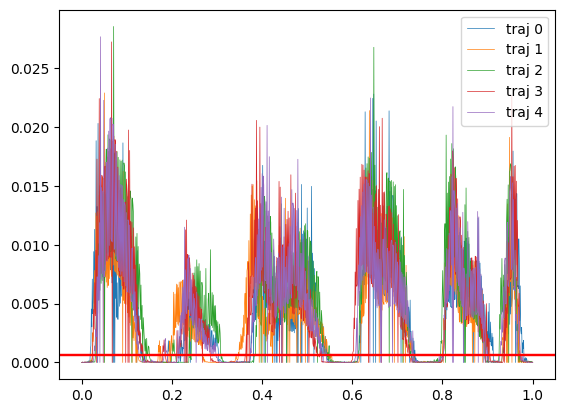

2024-08-16 16:15:26.398 | INFO     |  Creating segement of demos.
2024-08-16 16:15:26.402 | INFO     |  Creating segement of demos.
2024-08-16 16:15:26.409 | INFO     |  Creating segement of demos.
2024-08-16 16:15:26.414 | INFO     |  Creating segement of demos.
2024-08-16 16:15:26.420 | INFO     |  Creating segement of demos.
2024-08-16 16:15:26.424 | INFO     |  Creating segement of demos.
2024-08-16 16:15:26.427 | INFO     |  Creating segement of demos.
2024-08-16 16:15:26.429 | INFO     |  ... created 7 segments
2024-08-16 16:15:26.430 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:26.430 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:26.782 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:26.782 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:27.157 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:27.158 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:27.602 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:27.602 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:28.111 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:28.111 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:28.563 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:28.641 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:28.642 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:28.711 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:28.712 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:28.792 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:28.792 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:28.899 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:28.900 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:29.011 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:29.012 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:15:29.090 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:29.092 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:29.092 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:29.353 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:29.353 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:29.640 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:29.641 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:29.944 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:29.944 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:30.281 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:30.282 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-16 16:15:30.596 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:30.598 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:30.598 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:31.427 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:31.428 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:32.440 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:32.441 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:33.317 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:33.318 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:34.296 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:34.296 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

2024-08-16 16:15:35.327 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:35.408 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:35.409 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:36.062 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:36.062 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:36.784 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:36.785 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:37.434 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:37.435 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:38.099 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:38.099 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

2024-08-16 16:15:38.706 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:38.784 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:38.784 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:39.159 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:39.159 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:39.539 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:39.539 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:39.936 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:39.937 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:40.333 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:40.334 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:40.718 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:40.793 | INFO     |    Fitting candidate frame 1/5
2024-08-16 16:15:40.793 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:40.967 | INFO     |    Fitting candidate frame 2/5
2024-08-16 16:15:40.968 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:41.139 | INFO     |    Fitting candidate frame 3/5
2024-08-16 16:15:41.139 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:41.317 | INFO     |    Fitting candidate frame 4/5
2024-08-16 16:15:41.318 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:41.485 | INFO     |    Fitting candidate frame 5/5
2024-08-16 16:15:41.486 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:15:41.713 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:15:41.715 | INFO     |  Segmented trajs into 7 segments
2024-08-16 16:15:41.717 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3
Segment 0 -0.999934 -0.204199 -0.814708 -0.115161 -0.116681
Segment 1 -0.000528 -0.208888 -0.787179 -0.002846 -0.004919
Segment 2 -0.003804 -0.218612 -0.785923 -0.009934 -0.012689
Segment 3 -0.381821 -0.294789 -0.793847 -0.503123 -0.688306
Segment 4 -0.469694 -0.454391 -0.542878 -0.570971 -0.458039
Segment 5 -0.025097 -0.493632 -0.788679 -0.028469 -0.020222
Segment 6 -0.018316 -0.319240 -0.757284 -0.032247 -0.028943
2024-08-16 16:15:41.719 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3
Segment 0  1.000000  0.204212  0.814763  0.115168  0.116688
Segment 1  0.000670  0.265363  1.000000  0.003615  0.006248
Segment 2  0.004840  0.278160  1.000000  0.012640  0.016145
Segment 3  0.480976 

Fitting segments:   0%|          | 0/7 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/12 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/9 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/7 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[1.41e+020, 1.60e+020, 1.80e+020, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.38e+013, 3.77e+013, 5.83e+013, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [4.45e-023, 9.07e-023, 1.80e-022, ..., 1.52e-132, 4.87e-133,
          1.38e-133],
         ...,
         [7.04e-264, 9.57e-264, 1.29e-263, ..., 3.60e+009, 1.51e+009,
          6.15e+008],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 4.06e+016, 2.30e+016,
          1.27e+016],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.06e+020, 9.33e+019,
          8.09e+019]]),
  array([[3.56e+09, 3.64e+09, 3.65e+09, 3.58e+09, 3.45e+09, 1.77e+10,
          1.96e+10, 2.12e+10, 2.24e+10, 2.33e+10, 2.36e+10, 2.35e+10,
          2.30e+10, 2.23e+10, 2.09e+10, 1.92e+10, 1.73e+10, 1.53e+10,
          1.33e+10, 1.14e+10, 9.48e+09, 7.76e+09, 6.21e+09, 4.88e+09,
          3.94e+09, 3.03e+09, 2.22e+09, 1.55e+09, 9.81e+08, 6.26e+08,
          4.22e+08, 2.83e+08, 1.86e+08, 1.20e+08, 7.55e+07, 4.67e+07,
          3.

In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


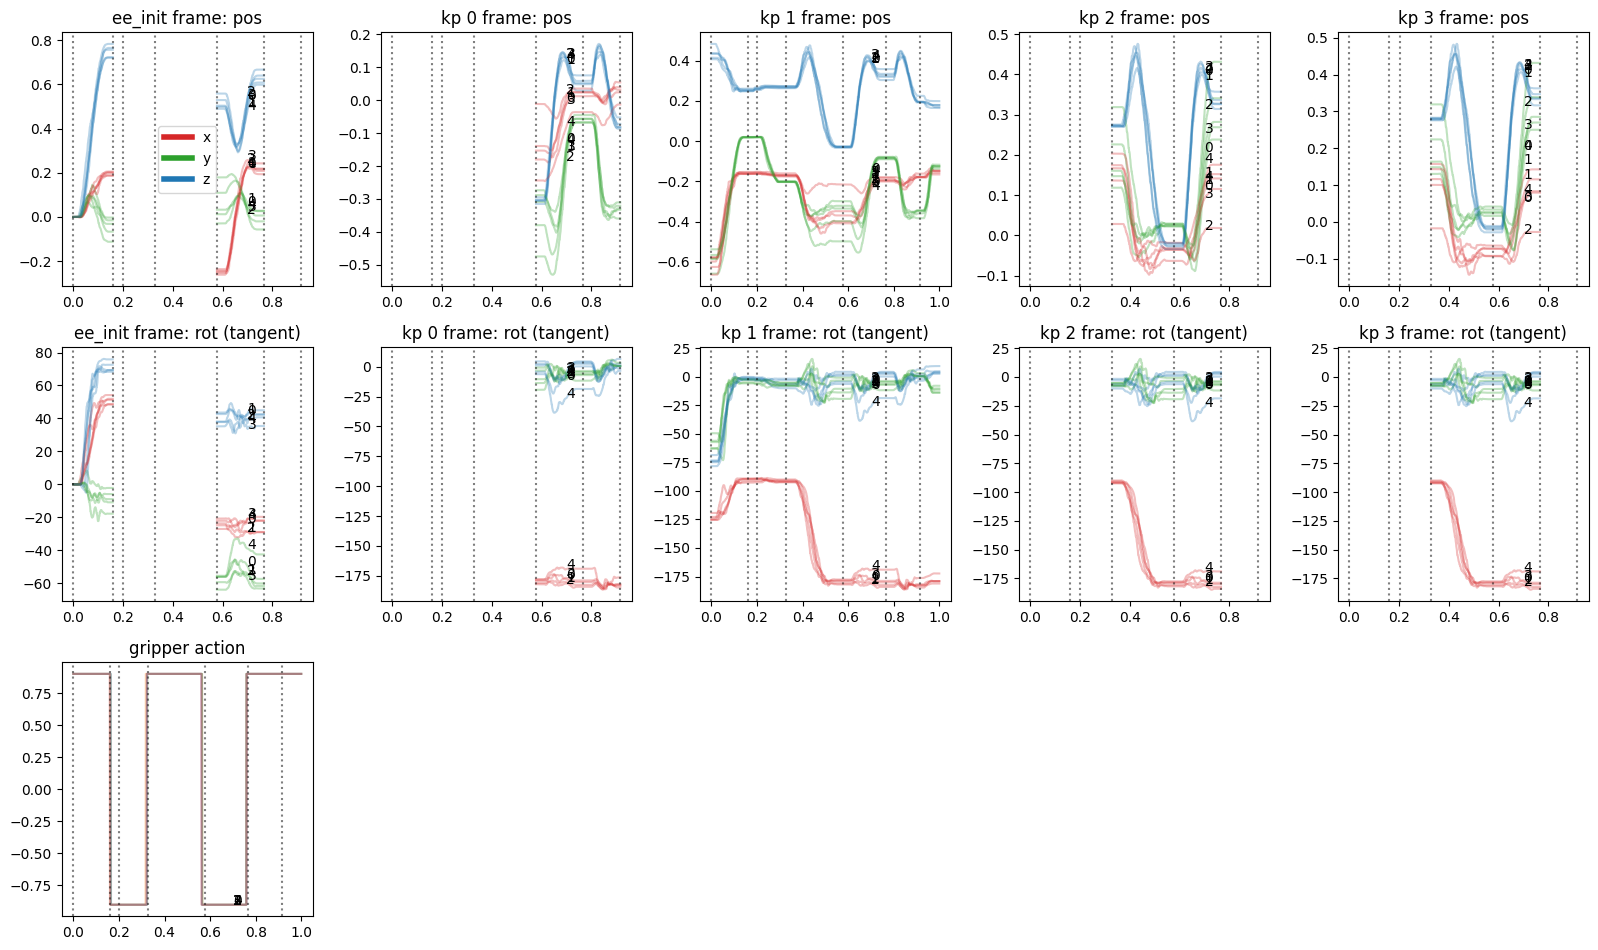

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, time_based=True,)


In [13]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.EM_HMM,))


2024-08-16 16:15:50.373 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:15:50.373 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-16 16:15:50.378 | INFO     |  HMM EM ...
2024-08-16 16:15:50.384 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-16 16:15:50.470 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-16 16:15:52.696 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.69e-007, 2.35e-007, 3.25e-007, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [3.16e-043, 5.66e-043, 1.00e-042, ..., 1.43e-152, 5.22e-153,
          1.71e-153],
         ...,
         [4.99e-284, 5.97e-284, 7.19e-284, ..., 3.38e-011, 1.61e-011,
          7.61e-012],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 3.82e-004, 2.46e-004,
          1.58e-004],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 2.30e-01,
          1.90e-01, 1.55e-01, 1.26e-01, 1.01e-01, 8.01e-02, 6.34e-02,
          4.99e-02, 3.91e-02, 3.05e-02, 2.37e-02, 1.83e-02, 1.41e-02,
          1.09e-02, 8.34e-03, 6.38e-03, 4.88e-03, 3.72e-03, 2.82e-03,
          2.03e-03, 1.34e-03, 9.34e-04, 6.35e-04, 4.00e-04, 2.66e-04,
          1.90e-04, 1.38e-04, 9.96e-05, 7.19e-05, 5.18e-05, 3.71e-05,
          1.

2024-08-16 16:16:09.613 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-16 16:16:09.926 | WARNING  |  Skippig NaN Gaussians.


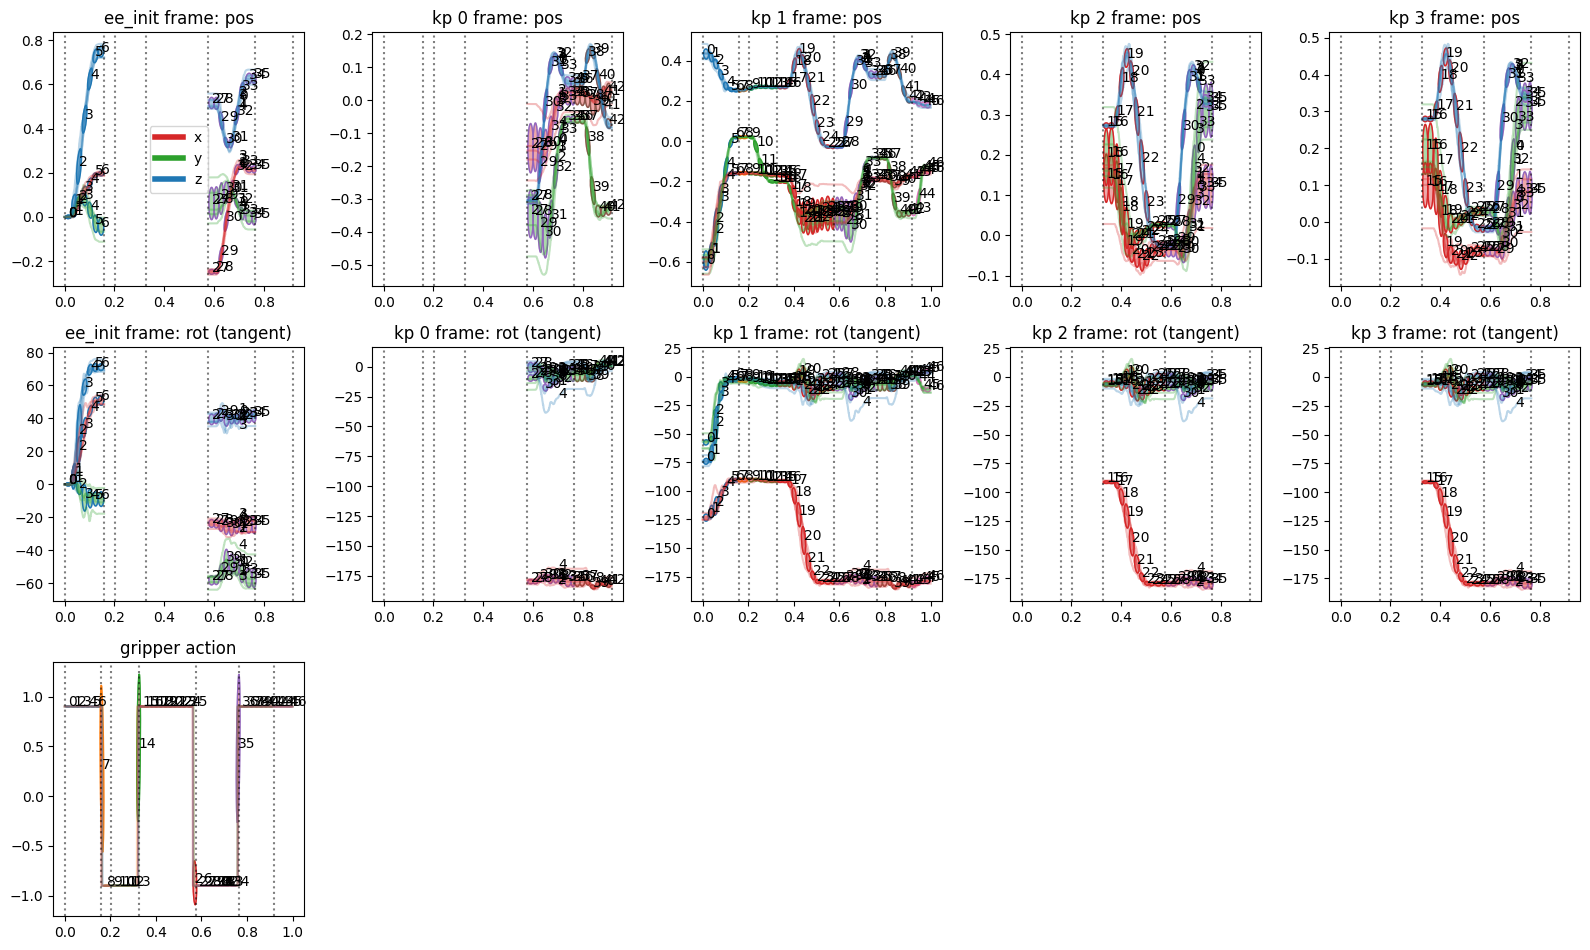

In [14]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


In [15]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-16 16:16:15.326 | INFO     |  Saving model:


2024-08-16 16:16:15.476 | INFO     |  Did not specify time_based, deciding automatically.


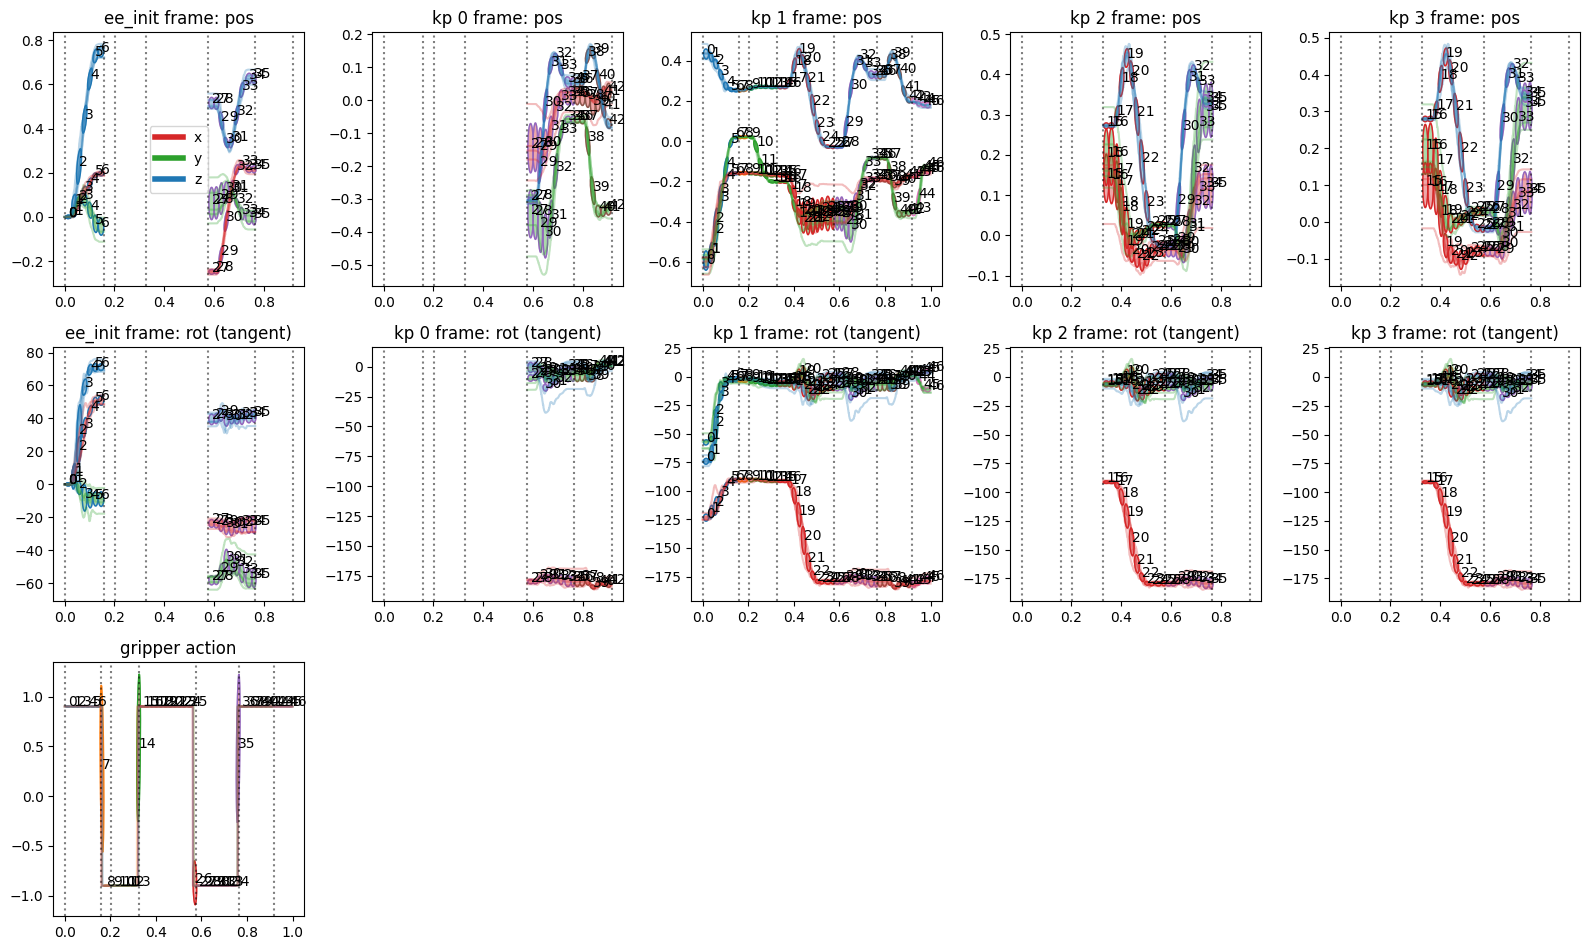

In [16]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


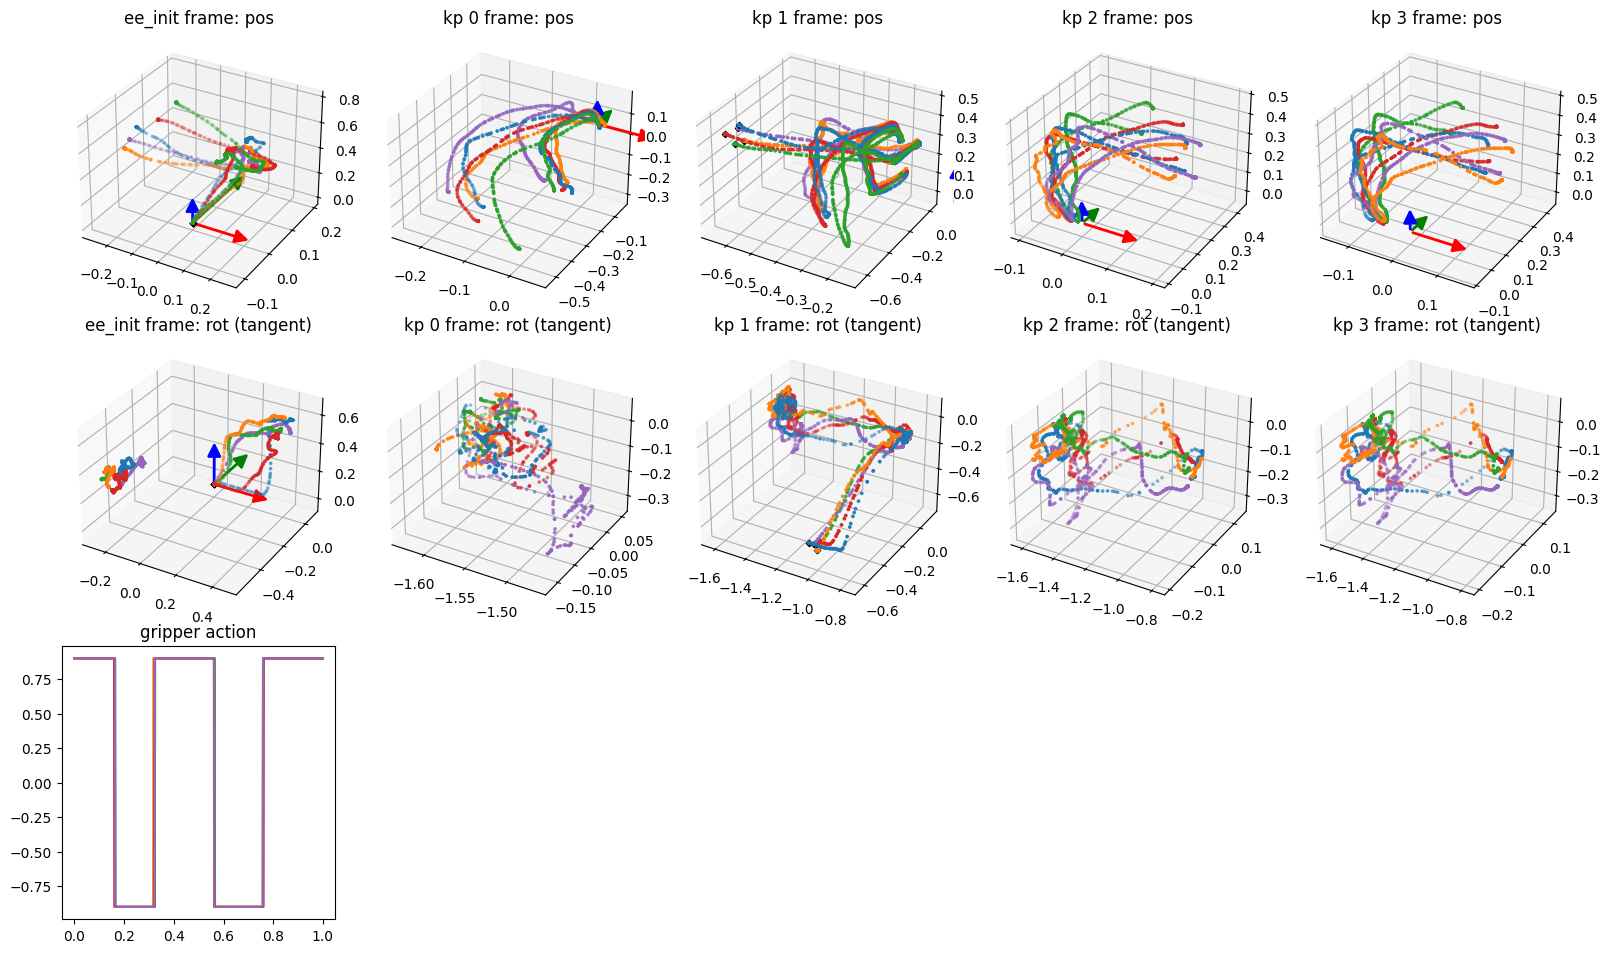

In [17]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [18]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-16 16:16:23.108 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-16 16:16:23.195 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[0.75]]), array([[1.]]), array([[0.99]]), array([[1.]]), array([[0.87]]))
2024-08-16 16:16:23.195 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:16:23.273 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:16:23.386 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:16:23.420 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:16:23.470 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:16:23.731 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:16:24.014 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:16:24.104 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:16:24.132 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

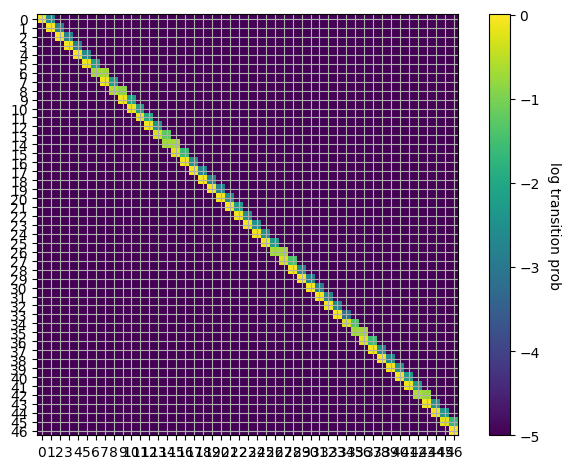

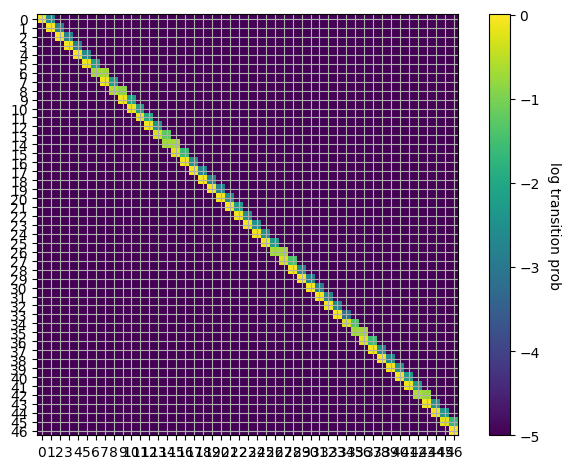

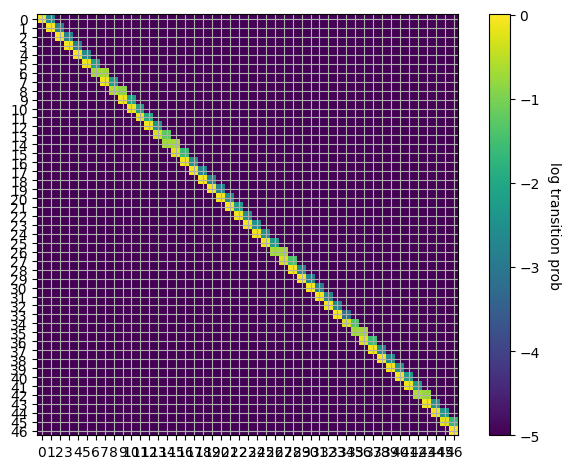

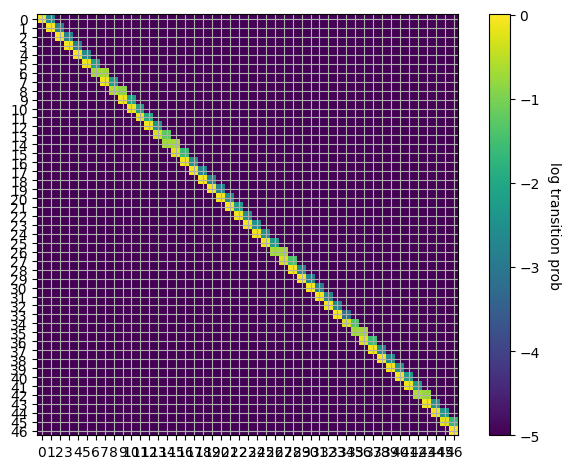

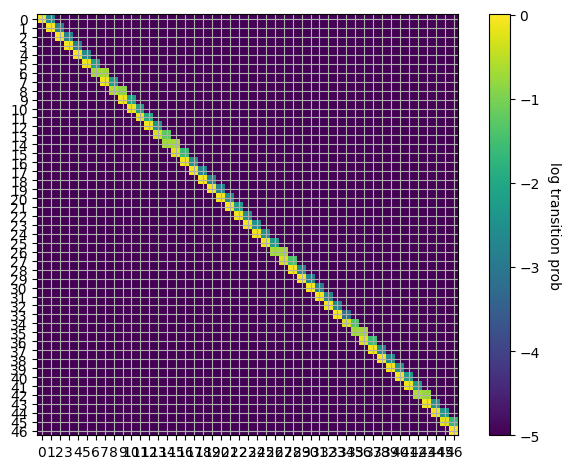

In [19]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)


2024-08-16 16:17:32.313 | INFO     |  Taking frame origins from demos.


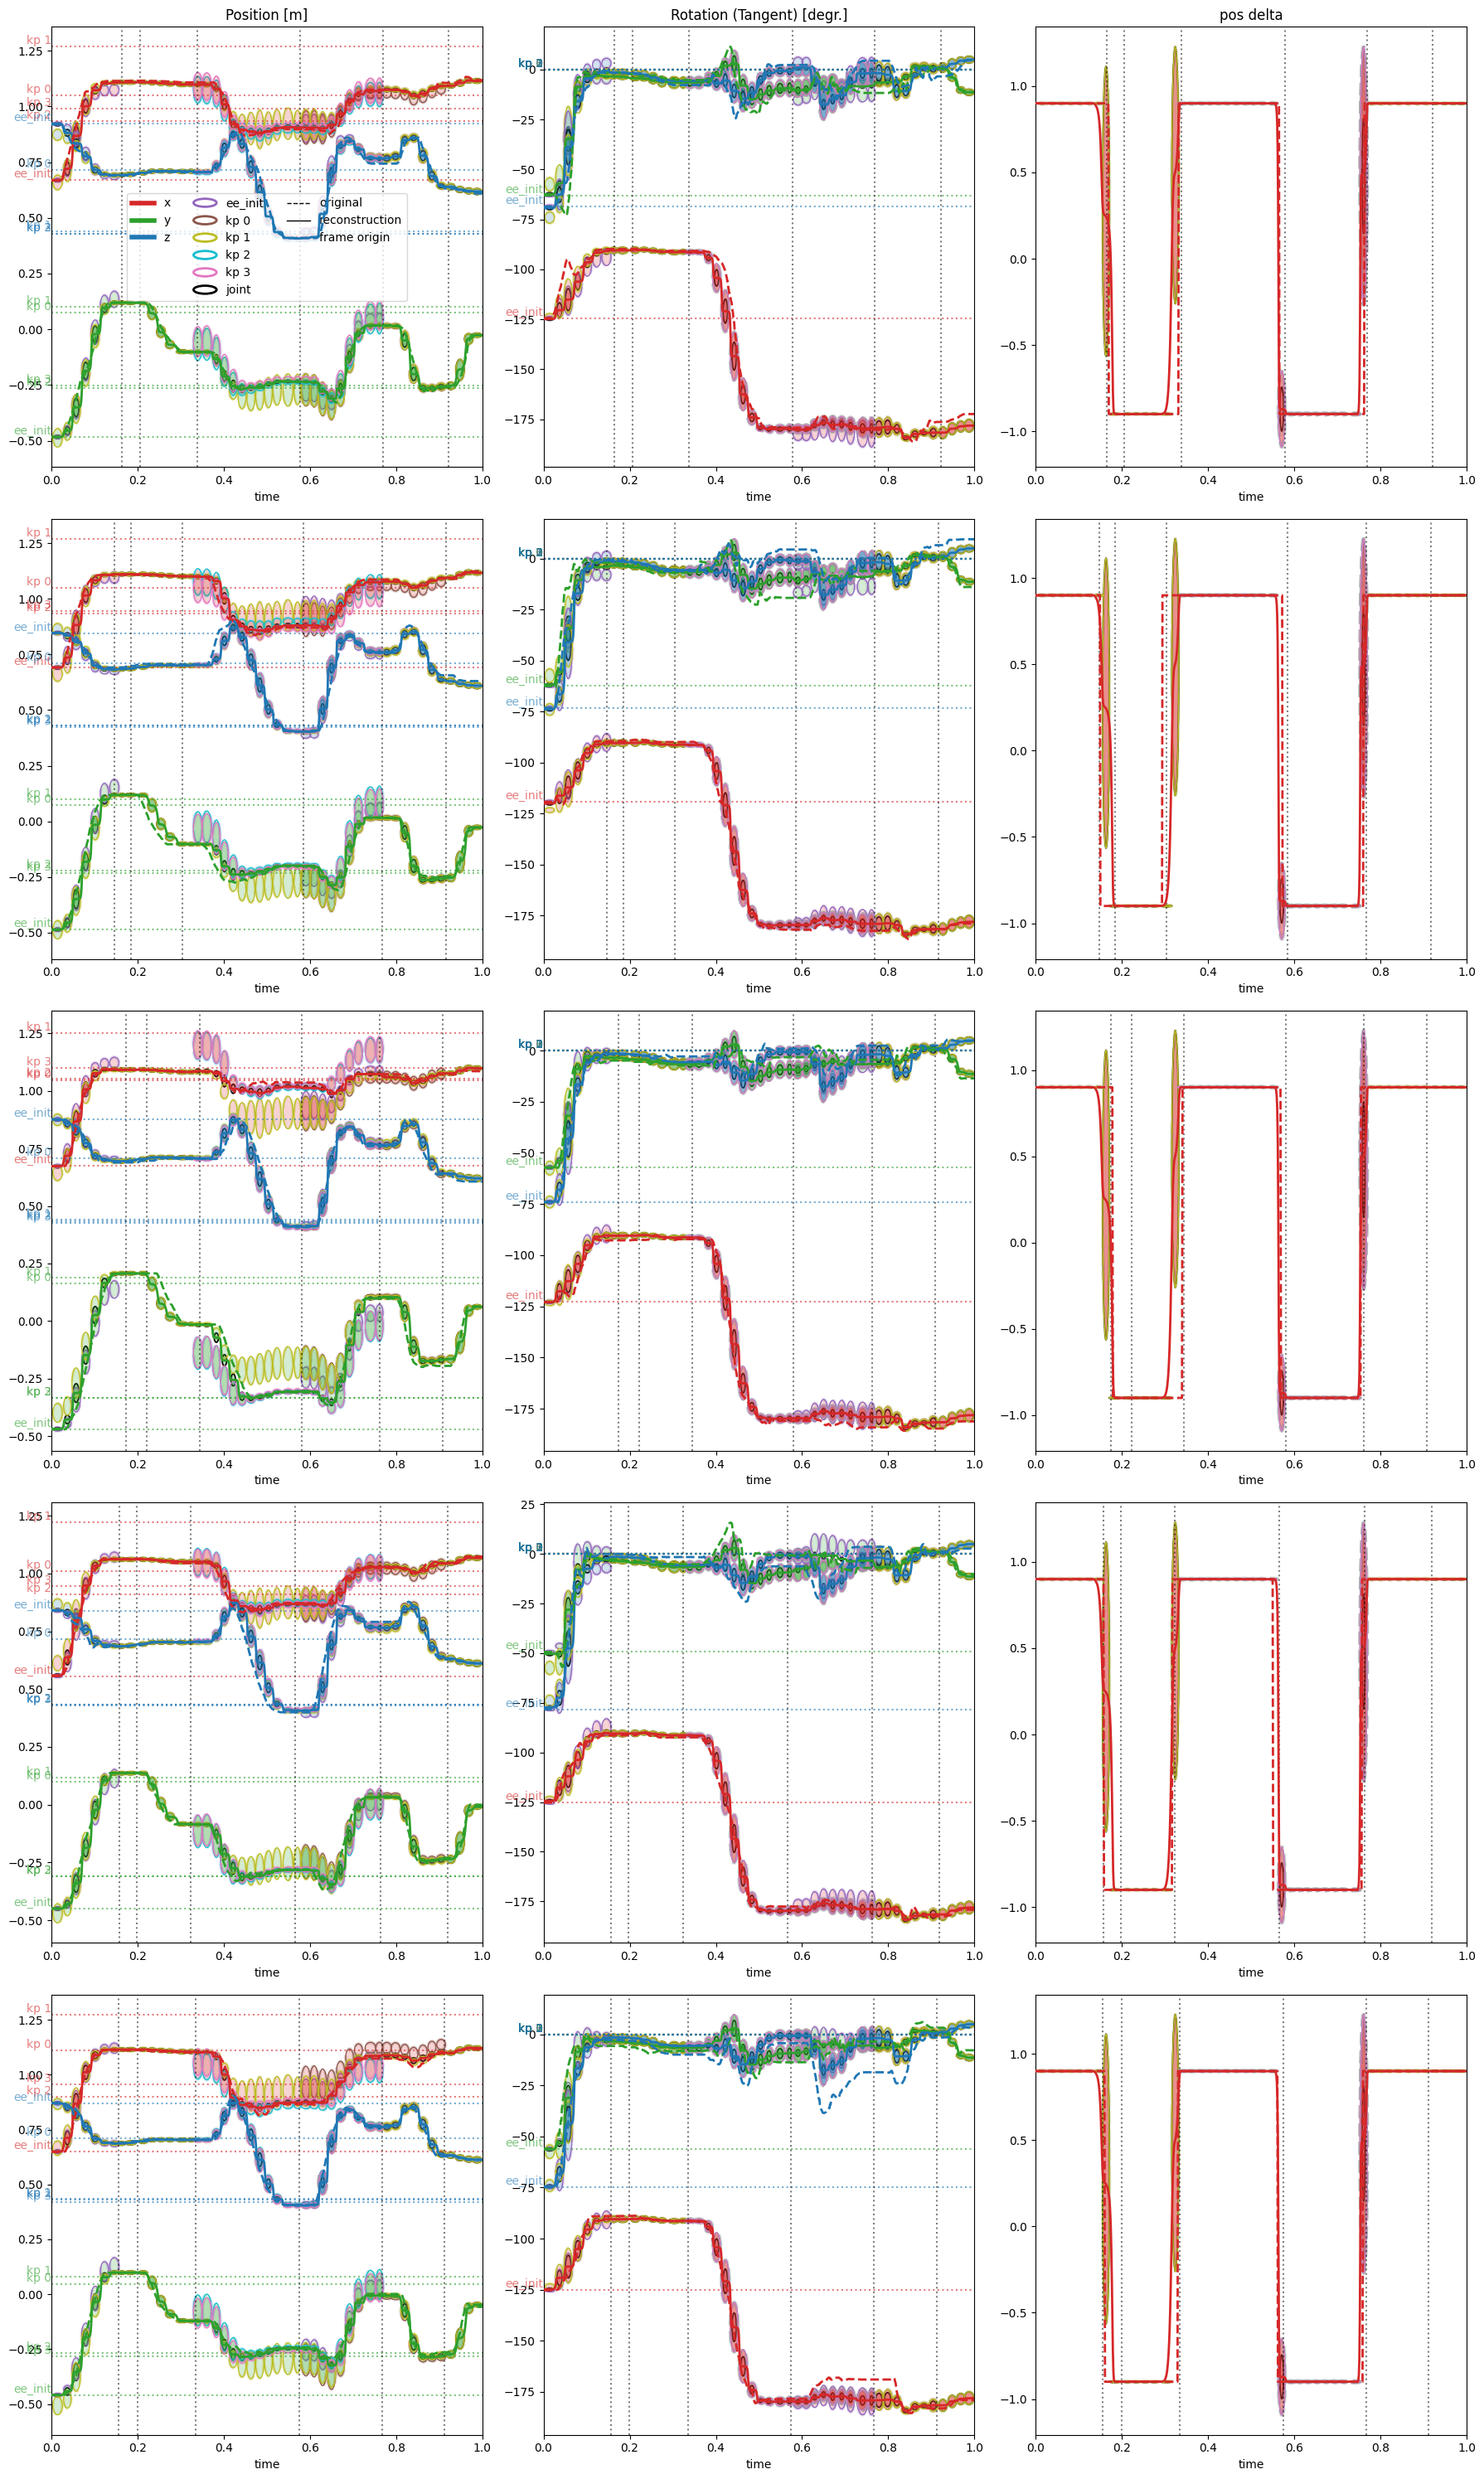

In [20]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


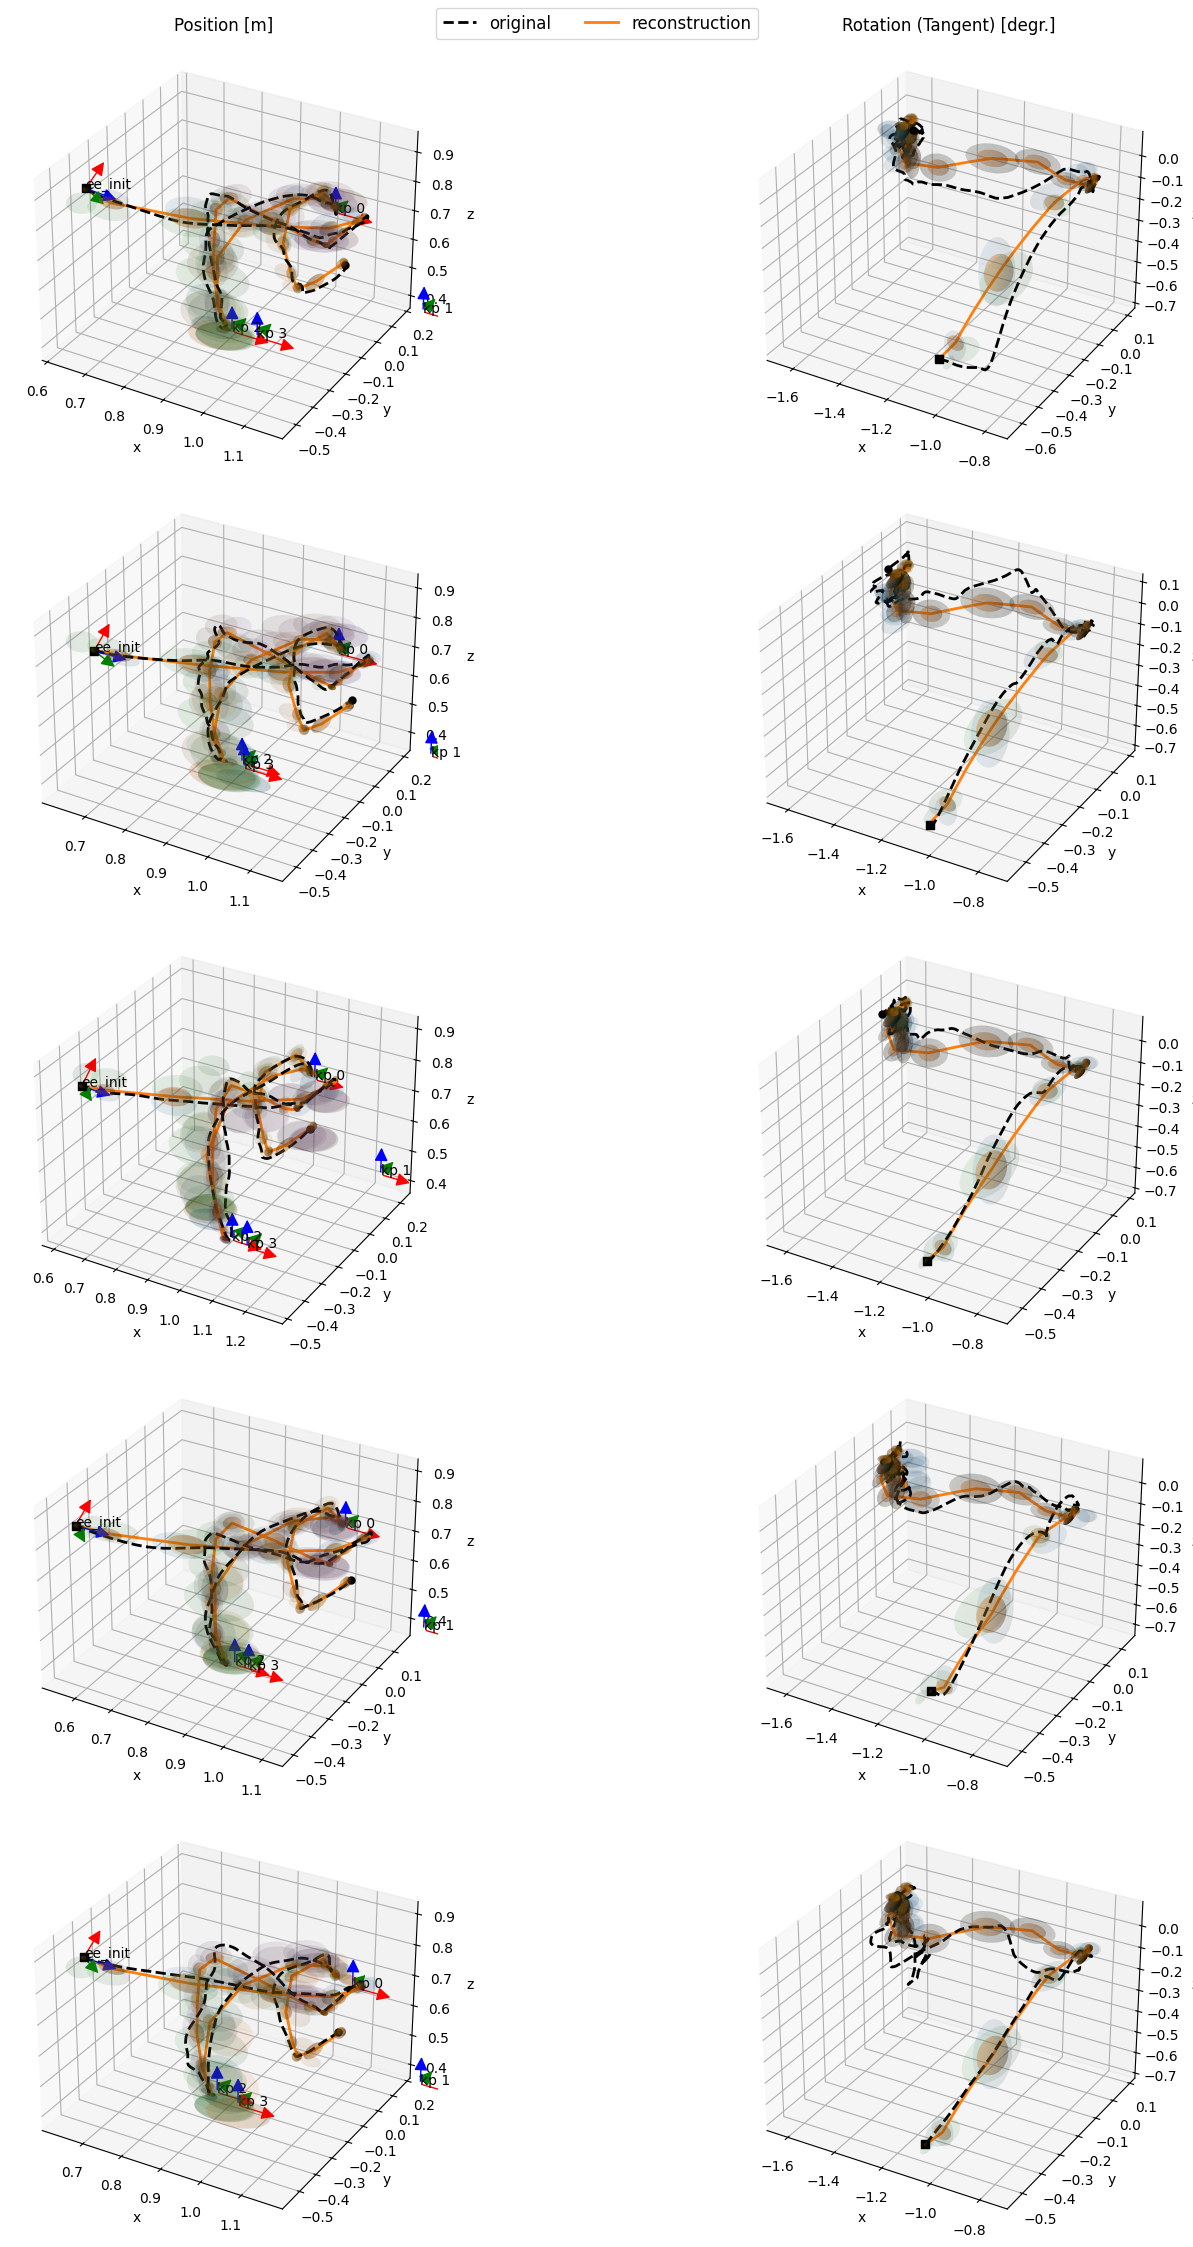

In [21]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=False, per_segment=False)